# Preprocessing Training Data

The Ground Truth masks are a bit problematic, because often only one of multiple grains are included in the ground truth mask.
There are some events of the same image being present twice, with two different ground truth masks.
This notebook will look at finding these duplicate images and combining the masks into one.

## To Do
1. Create list of patient ID (duplicate images will always belong to the same patient as eachother).
1. Search through images of each patient, checking for duplicates.
1. If there is a duplicate, combine the masks, overwrite the mask, and delete the second image/mask occurrence.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys
import hashlib
from PIL import Image
from collections import defaultdict

sys.path.append('../src')
from utils import return_image_and_mask, return_image, return_mask, plot_image_and_mask

In [3]:
!ls ../data/

best_model_test_postproc_tiff   test_dataset
classification_labels_sub2.xlsx training_dataset
data.md                         validation_dataset
overlaid_mask_edges


In [4]:
DATA_DIR = '../data'

In [5]:
# Get full image path by adding filename to base path

# Get the paths
train_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*.jpg')])
val_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*.jpg')])

print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")

Train length: 593
Val length: 91


In [6]:
# Sort paths to make sorting by patient easier
train_paths.sort()
val_paths.sort()

In [7]:
idx = 70
print(train_paths[idx:idx+10])

['training_dataset/BM/BM32_1' 'training_dataset/BM/BM32_2'
 'training_dataset/BM/BM32_3' 'training_dataset/BM/BM32_4'
 'training_dataset/BM/BM32_5' 'training_dataset/BM/BM33_1'
 'training_dataset/BM/BM35_1' 'training_dataset/BM/BM35_2'
 'training_dataset/BM/BM35_3' 'training_dataset/BM/BM35_4']


## Removing Duplicates and Combining the Masks

We have the paths. Now make dictionary of the paths and the hashed images to check for duplicates.

In [8]:
def compute_image_hash(data_dir, path):

    image = return_image(data_dir, path)
    return hashlib.md5(image.tobytes()).hexdigest()

In [9]:
def image_hash_dict(data_dir, paths):

    image_hashes = {}

    for path in paths:
        image_hashes[path] = compute_image_hash(data_dir, path)

    return image_hashes

In [10]:
# Use default dict to see which image appears in multiple paths
# Takes dictionary with key: value pairs of image path: image hash
# Returns dictionary of hash values (that appear more than once), with list of paths as values
def get_image_duplicates(hashes):
    hash_path_dict = defaultdict(list)
        
    for path, image_hash in hashes.items():
        hash_path_dict[image_hash].append(path)

    duplicates = {k: v for k, v in hash_path_dict.items() if len(v) > 1}
    return duplicates


In [11]:
# Function that takes list of path names, and combines the masks of these paths. Clips to 1 to keep mask binary.
def combine_masks(data_dir, duplicate_paths):
    # all images and masks are (600,800)
    combined_mask = np.zeros(shape=(600,800))

    # for each path, return the mask and add to combined mask
    for path in duplicate_paths:
        combined_mask += return_mask(data_dir, path)

    # clip the mask
    combined_mask = np.clip(combined_mask, 0, 1)
    
    return combined_mask

In [12]:
# FUNCTION TO COMBINE DUPLICATE MASKS, SAVE NEW ONE AND DELETE DUPLICATES
def deal_with_duplicates(data_dir, paths):

    # Get path to hash dictionary
    print('getting hash dict...')
    hash_dict = image_hash_dict(data_dir, paths)

    # Get duplicates
    duplicates = get_image_duplicates(hash_dict)
    
    # For each set of duplicates,
    print('looping through duplicates...')
    for duplicate_paths in duplicates.values():
        
        # Combine masks into one
        combined_mask = combine_masks(data_dir, duplicate_paths)

        # Overwrite first mask
        first_path = duplicate_paths[0]
        combined_mask_img = Image.fromarray(combined_mask)
        
        # Save the single-channel image, overwriting the original file
        combined_mask_img.save(DATA_DIR + '/' + first_path + '_mask.tif')

        # Delete duplicate images and masks
        for path in duplicate_paths[1:]:
            os.remove(os.path.join(data_dir, path) + '.jpg')
            os.remove(os.path.join(data_dir, path) + '_mask.tif')
            print(f"Deleted {path} from the dataset.")
        
    print('done.')

In [14]:
deal_with_duplicates(DATA_DIR, val_paths)

getting hash dict...
looping through duplicates...
Deleted validation_dataset/BM/BM53_2 from the dataset.
Deleted validation_dataset/BM/BM58_2 from the dataset.
Deleted validation_dataset/BM/BM58_7 from the dataset.
Deleted validation_dataset/FM/FM79_6 from the dataset.
done.


In [47]:
# FUNCTION TO COMBINE DUPLICATE MASKS, SAVE NEW ONE AND DELETE DUPLICATES
def show_and_save_duplicates(data_dir, paths):

    # Get path to hash dictionary
    print('getting hash dict...')
    hash_dict = image_hash_dict(data_dir, paths)

    # Get duplicates
    duplicates = get_image_duplicates(hash_dict)
    
    # For each set of duplicates,
    print('looping through duplicates...')
    for duplicate_paths in duplicates.values():
        
        # Combine masks into one
        combined_mask = combine_masks(data_dir, duplicate_paths)

        # Overwrite first mask
        first_path = duplicate_paths[0]
        combined_mask_img = Image.fromarray(combined_mask)

        # Plot Image and mask pairs
        n=0
        for i in duplicate_paths:
            n += 1
            print(f"Image {i}")
            plot_image_and_mask(i, DATA_DIR)
            mask = return_mask(DATA_DIR, i)
            mask = mask * 255

            # Convert the numpy array to a PIL Image and save as JPG
            mask_image = Image.fromarray(mask)
            mask_image.save(f'example_mask_{n}.jpg', format='JPEG')

        # Plot Combined Mask
        print(f"Combined Mask")
        plt.imshow(combined_mask)
        plt.axis('off')
        plt.show()

        # Save combined mask
        combined_mask = np.where(combined_mask > 0, 255, 0).astype(np.uint8)
        combined_mask_image = Image.fromarray(combined_mask)
        combined_mask_image.save(f'example_combined_mask.jpg', format='JPEG')
        
    print('done.')

In [48]:
# Save example of duplicate image and combining masks
# Going to use BM37 as example
example_paths = [path for path in train_paths if 'BM37' in path]

In [49]:
example_paths

['training_dataset/BM/BM37_1',
 'training_dataset/BM/BM37_2',
 'training_dataset/BM/BM37_3',
 'training_dataset/BM/BM37_4',
 'training_dataset/BM/BM37_5',
 'training_dataset/BM/BM37_6']

getting hash dict...
looping through duplicates...
Image training_dataset/BM/BM37_3


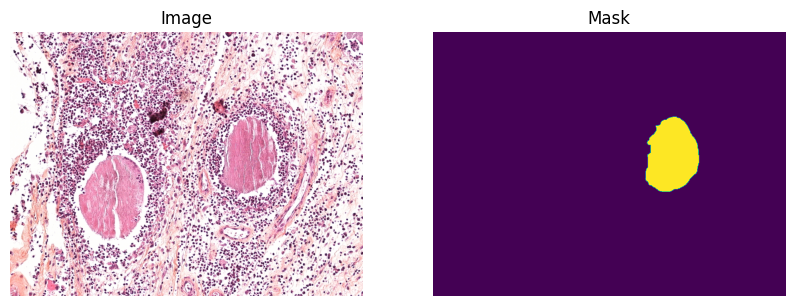

Image training_dataset/BM/BM37_4


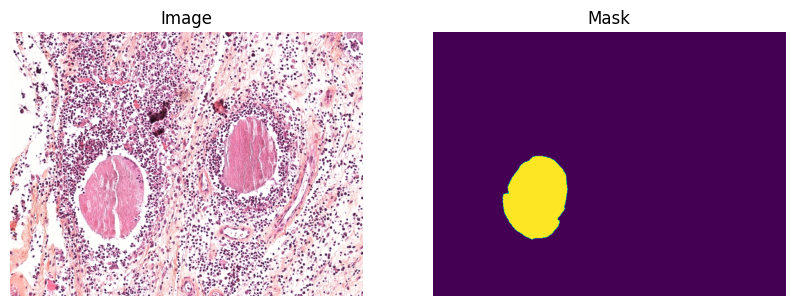

Combined Mask


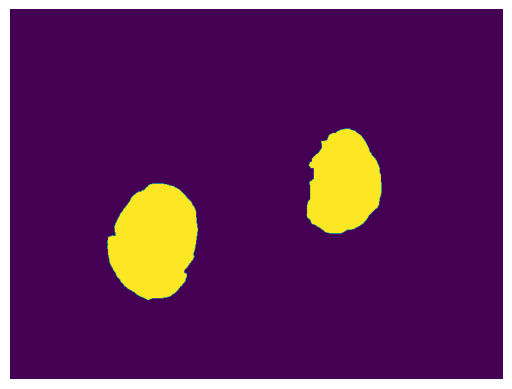

done.


In [50]:
show_and_save_duplicates(DATA_DIR, example_paths)